In [2]:
import os
import random

from __future__ import absolute_import, division, print_function, unicode_literals
import sys
print("Python executable:", sys.executable)
import tensorflow as tf
tf.config.experimental.enable_op_determinism()
print("TF 版本:", tf.__version__)
print("CUDA 版本:", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN 版本:", tf.sysconfig.get_build_info().get("cudnn_version"))

import tensorflow as tf; tf.config.list_physical_devices('GPU')
print("可用 GPU 设备:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import datasets, layers, models, Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2
print("OpenCV 版本:", cv2.__version__)
from matplotlib import pyplot
import h5py
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator




Python executable: E:\Anaconda3\python.exe
TF 版本: 2.18.0
CUDA 版本: None
cuDNN 版本: None
可用 GPU 设备: []
OpenCV 版本: 4.11.0


In [39]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0


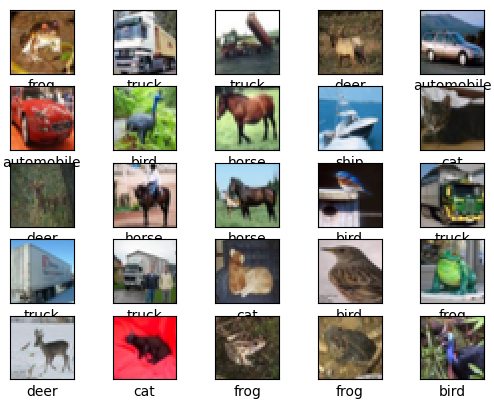

In [40]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(25):
    plt.subplot(5, 5, i + 1)  
    plt.xticks([])  
    plt.yticks([]) 
    plt.grid(False)  #
    plt.imshow(train_images[i])  
    plt.xlabel(class_names[train_labels[i][0]])  

plt.show() 

In [41]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.config.experimental.enable_op_determinism()

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """Build a stack of convolutional layers + Batch Normalization + activation functions, including L2 regularization."""
    conv = layers.Conv2D(num_filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(1e-3)) 
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10, dropout_rate=0.0):
    """
    Construct the ResNet V1 model, suitable for CIFAR-10.
    The depth must satisfy 6n+2, for example, ResNet-20 corresponds to n=3.
    dropout_rate: the dropout ratio applied after each residual block.
    """
    if (depth - 2) % 6 != 0:
        raise ValueError("depth require 6n+2")
    num_filters = 16
    num_res_blocks = (depth - 2) // 6

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=num_filters)

    # Three stacks, each containing num_res_blocks residual blocks.
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # For non-first stacks, the first residual block performs downsampling.
            if stack > 0 and res_block == 0:
                strides = 2
            # Residual block: two consecutive convolutional layers.
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            # If downsampling is needed, adjust the dimensions of x.
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1,
                                 strides=strides, activation=None, batch_normalization=False)
            # Residual connection.
            x = layers.add([x, y])
            x = layers.Activation('relu')(x)
            # Add dropout after each residual block.
            if dropout_rate > 0:
                x = layers.Dropout(dropout_rate)(x)
        # Add an extra dropout after each stack.
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
        num_filters *= 2

    # Classifier part: Global Average Pooling -> Flatten -> heavy Dropout -> Fully connected layer.
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    y = layers.Dropout(0.5)(y)  # Heavy dropout before the classifier.
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           kernel_initializer='he_normal')(y)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Model parameter settings.
input_shape = (32, 32, 3)
depth = 20       # For ResNet-20, 6*3+2=20.
num_classes = 10
dropout_rate = 0.3  # Use 30% dropout in the residual blocks.

# Load the CIFAR-10 dataset and normalize the pixel values.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding and apply label smoothing.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

# Data augmentation: add rotation, shift, zoom, and horizontal flip.
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)
datagen.fit(x_train)

# Construct the ResNet-20 model with strong regularization measures.
model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes, dropout_rate=dropout_rate)

# Use the label-smoothed categorical cross-entropy loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


In [42]:
#Pour afficher l'architecture du modele CNN
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_105 (Conv2D)           │ (None, 32, 32, 16)        │             448 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_95        │ (None, 32, 32, 16)        │              64 │ conv2d_105[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_95 (Activation)    │ (None, 32, 32, 16)        │               0 │ batch_normalization_95[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_106 (Conv2D)           │ (None, 32, 32, 16)        │           2,320 │ activation_95[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_96        │ (None, 32, 32, 16)        │              64 │ conv2d_106[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_96 (Activation)    │ (None, 32, 32, 16)        │               0 │ batch_normalization_96[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_107 (Conv2D)           │ (None, 32, 32, 16)        │           2,320 │ activation_96[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_97        │ (None, 32, 32, 16)        │              64 │ conv2d_107[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_45 (Add)                  │ (None, 32, 32, 16)        │               0 │ activation_95[0][0],       │
│                               │                           │                 │ batch_normalization_97[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_97 (Activation)    │ (None, 32, 32, 16)        │               0 │ add_45[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_39 (Dropout)          │ (None, 32, 32, 16)        │               0 │ activation_97[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_108 (Conv2D)           │ (None, 32, 32, 16)        │           2,320 │ dropout_39[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_98        │ (None, 32, 32, 16)        │              64 │ conv2d_108[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_98 (Activation)    │ (None, 32, 32, 16)        │               

 Total params: 274,442 (1.05 MB)

 Trainable params: 273,066 (1.04 MB)

 Non-trainable params: 1,376 (5.38 KB)

In [43]:
# Define callbacks: dynamically reduce learning rate, early stopping, and save the model with the best validation loss.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("resnet20_cifar10_best.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model (train for enough epochs; the early stopping mechanism will automatically halt training to prevent overfitting)
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=300,  # You can run many epochs as long as the validation performance is good
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stop, checkpoint],
                    shuffle=True)

# Save the trained model
model.save(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\model\resnet20_cifar10_final.h5")


Epoch 1/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1319 - loss: 5.6550
Epoch 1: val_loss improved from inf to 4.08494, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 218ms/step - accuracy: 0.1319 - loss: 5.6511 - val_accuracy: 0.1012 - val_loss: 4.0849 - learning_rate: 0.0010
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2280 - loss: 2.9289
Epoch 2: val_loss improved from 4.08494 to 3.60434, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 237ms/step - accuracy: 0.2281 - loss: 2.9285 - val_accuracy: 0.1069 - val_loss: 3.6043 - learning_rate: 0.0010
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2993 - loss: 2.4472
Epoch 3: val_loss improved from 3.60434 to 3.08221, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 232ms/step - accuracy: 0.2993 - loss: 2.4470 - val_accuracy: 0.1444 - val_loss: 3.0822 - learning_rate: 0.0010
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3632 - loss: 2.1905
Epoch 4: val_loss improved from 3.08221 to 2.54277, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 236ms/step - accuracy: 0.3633 - loss: 2.1903 - val_accuracy: 0.2329 - val_loss: 2.5428 - learning_rate: 0.0010
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4076 - loss: 2.0318
Epoch 5: val_loss improved from 2.54277 to 2.03177, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 238ms/step - accuracy: 0.4076 - loss: 2.0318 - val_accuracy: 0.3975 - val_loss: 2.0318 - learning_rate: 0.0010
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4456 - loss: 1.9209
Epoch 6: val_loss did not improve from 2.03177
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 235ms/step - accuracy: 0.4456 - loss: 1.9209 - val_accuracy: 0.3734 - val_loss: 2.1091 - learning_rate: 0.0010
Epoch 7/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4722 - loss: 1.8505
Epoch 7: val_loss improved from 2.03177 to 1.90160, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.4723 - loss: 1.8505 - val_accuracy: 0.4008 - val_loss: 1.9016 - learning_rate: 0.0010
Epoch 8/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5005 - loss: 1.7866
Epoch 8: val_loss improved from 1.90160 to 1.74776, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.5005 - loss: 1.7865 - val_accuracy: 0.4871 - val_loss: 1.7478 - learning_rate: 0.0010
Epoch 9/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5191 - loss: 1.7407
Epoch 9: val_loss did not improve from 1.74776
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.5191 - loss: 1.7407 - val_accuracy: 0.4606 - val_loss: 1.8612 - learning_rate: 0.0010
Epoch 10/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5294 - loss: 1.7168
Epoch 10: val_loss improved from 1.74776 to 1.60920, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.5294 - loss: 1.7168 - val_accuracy: 0.5642 - val_loss: 1.6092 - learning_rate: 0.0010
Epoch 11/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5434 - loss: 1.6857
Epoch 11: val_loss did not improve from 1.60920
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.5435 - loss: 1.6856 - val_accuracy: 0.4780 - val_loss: 1.7751 - learning_rate: 0.0010
Epoch 12/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5508 - loss: 1.6683
Epoch 12: val_loss did not improve from 1.60920
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.5508 - loss: 1.6683 - val_accuracy: 0.4498 - val_loss: 1.9475 - learning_rate: 0.0010
Epoch 13/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5649 - loss: 1.6394
Epoch 13: val_loss did not improve from 1.60920
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.5649 - loss: 1.6394 - val_accuracy: 0.4119 - val_loss: 2.2816 - learning_rate: 0.0010
Epoch 14/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.5742 - loss: 1.6205 - val_accuracy: 0.5855 - val_loss: 1.5714 - learning_rate: 0.0010
Epoch 15/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5802 - loss: 1.6075
Epoch 15: val_loss improved from 1.57143 to 1.55738, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.5802 - loss: 1.6075 - val_accuracy: 0.5919 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 16/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5962 - loss: 1.5795
Epoch 16: val_loss did not improve from 1.55738
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step - accuracy: 0.5962 - loss: 1.5795 - val_accuracy: 0.5801 - val_loss: 1.6088 - learning_rate: 0.0010
Epoch 17/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6027 - loss: 1.5666
Epoch 17: val_loss did not improve from 1.55738
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 234ms/step - accuracy: 0.6027 - loss: 1.5666 - val_accuracy: 0.3683 - val_loss: 2.7480 - learning_rate: 0.0010
Epoch 18/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6020 - loss: 1.5635
Epoch 18: val_loss did not improve from 1.55738
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6020 - loss: 1.5634 - val_accuracy: 0.5710 - val_loss: 1.6212 - learning_rate: 0.0010
Epoch 19/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6165 - loss: 1.5391 - val_accuracy: 0.6265 - val_loss: 1.4811 - learning_rate: 0.0010
Epoch 21/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6198 - loss: 1.5304
Epoch 21: val_loss did not improve from 1.48111
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6198 - loss: 1.5304 - val_accuracy: 0.5937 - val_loss: 1.5660 - learning_rate: 0.0010
Epoch 22/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6246 - loss: 1.5275
Epoch 22: val_loss did not improve from 1.48111
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6246 - loss: 1.5275 - val_accuracy: 0.5287 - val_loss: 1.8735 - learning_rate: 0.0010
Epoch 23/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6252 - loss: 1.5231
Epoch 23: val_loss did not improve from 1.48111
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6252 - loss: 1.5231 - val_accuracy: 0.6287 - val_loss: 1.4825 - learning_rate: 0.0010
Epoch 24/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6326 - loss: 1.5101 - val_accuracy: 0.6416 - val_loss: 1.4500 - learning_rate: 0.0010
Epoch 25/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6364 - loss: 1.4987
Epoch 25: val_loss did not improve from 1.45001
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.6364 - loss: 1.4987 - val_accuracy: 0.6028 - val_loss: 1.5378 - learning_rate: 0.0010
Epoch 26/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6441 - loss: 1.4913
Epoch 26: val_loss did not improve from 1.45001
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6441 - loss: 1.4913 - val_accuracy: 0.5895 - val_loss: 1.5825 - learning_rate: 0.0010
Epoch 27/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6403 - loss: 1.4958
Epoch 27: val_loss did not improve from 1.45001
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.6403 - loss: 1.4957 - val_accuracy: 0.6242 - val_loss: 1.5165 - learning_rate: 0.0010
Epoch 28/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6500 - loss: 1.4789 - val_accuracy: 0.6581 - val_loss: 1.4237 - learning_rate: 0.0010
Epoch 30/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6522 - loss: 1.4817
Epoch 30: val_loss did not improve from 1.42373
391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 223ms/step - accuracy: 0.6522 - loss: 1.4817 - val_accuracy: 0.6050 - val_loss: 1.5536 - learning_rate: 0.0010
Epoch 31/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6526 - loss: 1.4745
Epoch 31: val_loss did not improve from 1.42373
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.6526 - loss: 1.4745 - val_accuracy: 0.6408 - val_loss: 1.4466 - learning_rate: 0.0010
Epoch 32/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6602 - loss: 1.4640
Epoch 32: val_loss did not improve from 1.42373
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6602 - loss: 1.4641 - val_accuracy: 0.6525 - val_loss: 1.4300 - learning_rate: 0.0010
Epoch 33/

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6651 - loss: 1.4480 - val_accuracy: 0.6757 - val_loss: 1.3800 - learning_rate: 0.0010
Epoch 35/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6663 - loss: 1.4524
Epoch 35: val_loss did not improve from 1.37998
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6663 - loss: 1.4524 - val_accuracy: 0.6314 - val_loss: 1.4751 - learning_rate: 0.0010
Epoch 36/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6752 - loss: 1.4418
Epoch 36: val_loss did not improve from 1.37998
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6752 - loss: 1.4418 - val_accuracy: 0.6750 - val_loss: 1.3813 - learning_rate: 0.0010
Epoch 37/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6719 - loss: 1.4417
Epoch 37: val_loss did not improve from 1.37998
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6719 - loss: 1.4417 - val_accuracy: 0.6672 - val_loss: 1.4406 - learning_rate: 0.0010
Epoch 38/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6785 - loss: 1.4270 - val_accuracy: 0.6819 - val_loss: 1.3762 - learning_rate: 0.0010
Epoch 44/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6853 - loss: 1.4176
Epoch 44: val_loss improved from 1.37616 to 1.35946, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.6853 - loss: 1.4176 - val_accuracy: 0.6925 - val_loss: 1.3595 - learning_rate: 0.0010
Epoch 45/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6858 - loss: 1.4193
Epoch 45: val_loss improved from 1.35946 to 1.31035, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6858 - loss: 1.4193 - val_accuracy: 0.7164 - val_loss: 1.3104 - learning_rate: 0.0010
Epoch 46/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6873 - loss: 1.4180
Epoch 46: val_loss did not improve from 1.31035
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6873 - loss: 1.4180 - val_accuracy: 0.5557 - val_loss: 1.8164 - learning_rate: 0.0010
Epoch 47/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6857 - loss: 1.4200
Epoch 47: val_loss did not improve from 1.31035
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 228ms/step - accuracy: 0.6857 - loss: 1.4200 - val_accuracy: 0.6293 - val_loss: 1.5256 - learning_rate: 0.0010
Epoch 48/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6887 - loss: 1.4102
Epoch 48: val_loss did not improve from 1.31035
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6887 - loss: 1.4102 - val_accuracy: 0.6691 - val_loss: 1.4360 - learning_rate: 0.0010
Epoch 49/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step - accuracy: 0.6886 - loss: 1.4105 - val_accuracy: 0.7235 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 50/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6871 - loss: 1.4107
Epoch 50: val_loss did not improve from 1.28018
391/391 ━━━━━━━━━━━━━━━━━━━━ 138s 224ms/step - accuracy: 0.6871 - loss: 1.4108 - val_accuracy: 0.6507 - val_loss: 1.4851 - learning_rate: 0.0010
Epoch 51/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6904 - loss: 1.4097
Epoch 51: val_loss did not improve from 1.28018
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 235ms/step - accuracy: 0.6904 - loss: 1.4097 - val_accuracy: 0.7104 - val_loss: 1.3368 - learning_rate: 0.0010
Epoch 52/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6924 - loss: 1.4011
Epoch 52: val_loss did not improve from 1.28018
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 228ms/step - accuracy: 0.6923 - loss: 1.4011 - val_accuracy: 0.7088 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 53/

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6938 - loss: 1.4027 - val_accuracy: 0.7401 - val_loss: 1.2493 - learning_rate: 0.0010
Epoch 54/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6972 - loss: 1.3988
Epoch 54: val_loss did not improve from 1.24933
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.6972 - loss: 1.3988 - val_accuracy: 0.6840 - val_loss: 1.4115 - learning_rate: 0.0010
Epoch 55/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6935 - loss: 1.4037
Epoch 55: val_loss did not improve from 1.24933
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6935 - loss: 1.4036 - val_accuracy: 0.7019 - val_loss: 1.3452 - learning_rate: 0.0010
Epoch 56/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6955 - loss: 1.3970
Epoch 56: val_loss did not improve from 1.24933
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.6954 - loss: 1.3971 - val_accuracy: 0.6912 - val_loss: 1.3407 - learning_rate: 0.0010
Epoch 57/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.7228 - loss: 1.3361 - val_accuracy: 0.7346 - val_loss: 1.2462 - learning_rate: 5.0000e-04
Epoch 65/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7253 - loss: 1.3165
Epoch 65: val_loss did not improve from 1.24615
391/391 ━━━━━━━━━━━━━━━━━━━━ 138s 221ms/step - accuracy: 0.7253 - loss: 1.3164 - val_accuracy: 0.6429 - val_loss: 1.5137 - learning_rate: 5.0000e-04
Epoch 66/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7316 - loss: 1.3053
Epoch 66: val_loss did not improve from 1.24615
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7316 - loss: 1.3053 - val_accuracy: 0.7306 - val_loss: 1.2567 - learning_rate: 5.0000e-04
Epoch 67/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7283 - loss: 1.3057
Epoch 67: val_loss improved from 1.24615 to 1.16596, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.7283 - loss: 1.3057 - val_accuracy: 0.7704 - val_loss: 1.1660 - learning_rate: 5.0000e-04
Epoch 68/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7358 - loss: 1.2926
Epoch 68: val_loss did not improve from 1.16596
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.7358 - loss: 1.2926 - val_accuracy: 0.7230 - val_loss: 1.2502 - learning_rate: 5.0000e-04
Epoch 69/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7353 - loss: 1.2859
Epoch 69: val_loss did not improve from 1.16596
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7352 - loss: 1.2859 - val_accuracy: 0.7225 - val_loss: 1.2731 - learning_rate: 5.0000e-04
Epoch 70/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7324 - loss: 1.2936
Epoch 70: val_loss did not improve from 1.16596
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7324 - loss: 1.2936 - val_accuracy: 0.7042 - val_loss: 1.3155 - learning_rate: 5.000

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7530 - loss: 1.2298 - val_accuracy: 0.7675 - val_loss: 1.1510 - learning_rate: 2.5000e-04
Epoch 80/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7584 - loss: 1.2187
Epoch 80: val_loss improved from 1.15099 to 1.07378, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7584 - loss: 1.2187 - val_accuracy: 0.7986 - val_loss: 1.0738 - learning_rate: 2.5000e-04
Epoch 81/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7596 - loss: 1.2197
Epoch 81: val_loss improved from 1.07378 to 1.06073, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 228ms/step - accuracy: 0.7596 - loss: 1.2198 - val_accuracy: 0.8013 - val_loss: 1.0607 - learning_rate: 2.5000e-04
Epoch 82/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7577 - loss: 1.2127
Epoch 82: val_loss did not improve from 1.06073
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 228ms/step - accuracy: 0.7577 - loss: 1.2127 - val_accuracy: 0.7810 - val_loss: 1.1204 - learning_rate: 2.5000e-04
Epoch 83/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7575 - loss: 1.2104
Epoch 83: val_loss did not improve from 1.06073
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.7575 - loss: 1.2104 - val_accuracy: 0.7876 - val_loss: 1.0927 - learning_rate: 2.5000e-04
Epoch 84/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7635 - loss: 1.2110
Epoch 84: val_loss did not improve from 1.06073
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 228ms/step - accuracy: 0.7635 - loss: 1.2110 - val_accuracy: 0.7636 - val_loss: 1.1581 - learning_rate: 2.500

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - accuracy: 0.7733 - loss: 1.1735 - val_accuracy: 0.7995 - val_loss: 1.0565 - learning_rate: 1.2500e-04
Epoch 93/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7774 - loss: 1.1662
Epoch 93: val_loss did not improve from 1.05651
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7774 - loss: 1.1662 - val_accuracy: 0.7828 - val_loss: 1.1076 - learning_rate: 1.2500e-04
Epoch 94/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7756 - loss: 1.1658
Epoch 94: val_loss improved from 1.05651 to 1.01536, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.7756 - loss: 1.1658 - val_accuracy: 0.8142 - val_loss: 1.0154 - learning_rate: 1.2500e-04
Epoch 95/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7791 - loss: 1.1562
Epoch 95: val_loss did not improve from 1.01536
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7791 - loss: 1.1562 - val_accuracy: 0.7856 - val_loss: 1.0895 - learning_rate: 1.2500e-04
Epoch 96/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7800 - loss: 1.1581
Epoch 96: val_loss did not improve from 1.01536
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7800 - loss: 1.1581 - val_accuracy: 0.8169 - val_loss: 1.0155 - learning_rate: 1.2500e-04
Epoch 97/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7790 - loss: 1.1536
Epoch 97: val_loss did not improve from 1.01536
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7790 - loss: 1.1536 - val_accuracy: 0.7964 - val_loss: 1.0628 - learning_rate: 1.250

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7785 - loss: 1.1544 - val_accuracy: 0.8142 - val_loss: 1.0134 - learning_rate: 1.2500e-04
Epoch 100/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7798 - loss: 1.1506
Epoch 100: val_loss did not improve from 1.01338
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.7798 - loss: 1.1506 - val_accuracy: 0.7999 - val_loss: 1.0526 - learning_rate: 1.2500e-04
Epoch 101/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7814 - loss: 1.1455
Epoch 101: val_loss did not improve from 1.01338
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 232ms/step - accuracy: 0.7814 - loss: 1.1455 - val_accuracy: 0.7888 - val_loss: 1.0825 - learning_rate: 1.2500e-04
Epoch 102/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7812 - loss: 1.1468
Epoch 102: val_loss did not improve from 1.01338
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step - accuracy: 0.7812 - loss: 1.1468 - val_accuracy: 0.7971 - val_loss: 1.0501 - learning_rate:

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7857 - loss: 1.1329 - val_accuracy: 0.8186 - val_loss: 0.9930 - learning_rate: 6.2500e-05
Epoch 111/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7874 - loss: 1.1277
Epoch 111: val_loss did not improve from 0.99298
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7874 - loss: 1.1277 - val_accuracy: 0.8177 - val_loss: 1.0020 - learning_rate: 6.2500e-05
Epoch 112/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7909 - loss: 1.1201
Epoch 112: val_loss did not improve from 0.99298
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7909 - loss: 1.1201 - val_accuracy: 0.8180 - val_loss: 1.0036 - learning_rate: 6.2500e-05
Epoch 113/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7932 - loss: 1.1144
Epoch 113: val_loss did not improve from 0.99298
391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 221ms/step - accuracy: 0.7932 - loss: 1.1144 - val_accuracy: 0.8041 - val_loss: 1.0385 - learning_rate

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7922 - loss: 1.1110 - val_accuracy: 0.8221 - val_loss: 0.9865 - learning_rate: 3.1250e-05
Epoch 123/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7936 - loss: 1.1059
Epoch 123: val_loss did not improve from 0.98646
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7936 - loss: 1.1059 - val_accuracy: 0.8214 - val_loss: 0.9934 - learning_rate: 3.1250e-05
Epoch 124/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7966 - loss: 1.1040
Epoch 124: val_loss did not improve from 0.98646
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7966 - loss: 1.1040 - val_accuracy: 0.8137 - val_loss: 1.0029 - learning_rate: 3.1250e-05
Epoch 125/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7974 - loss: 1.1050
Epoch 125: val_loss did not improve from 0.98646
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7974 - loss: 1.1050 - val_accuracy: 0.8118 - val_loss: 1.0192 - learning_rate:

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.7955 - loss: 1.1021 - val_accuracy: 0.8246 - val_loss: 0.9797 - learning_rate: 3.1250e-05
Epoch 131/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7966 - loss: 1.0998
Epoch 131: val_loss did not improve from 0.97974
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7966 - loss: 1.0998 - val_accuracy: 0.8157 - val_loss: 0.9967 - learning_rate: 3.1250e-05
Epoch 132/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7980 - loss: 1.0957
Epoch 132: val_loss improved from 0.97974 to 0.97750, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7980 - loss: 1.0957 - val_accuracy: 0.8266 - val_loss: 0.9775 - learning_rate: 3.1250e-05
Epoch 133/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7976 - loss: 1.0984
Epoch 133: val_loss did not improve from 0.97750
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7976 - loss: 1.0984 - val_accuracy: 0.8173 - val_loss: 0.9975 - learning_rate: 3.1250e-05
Epoch 134/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7988 - loss: 1.0990
Epoch 134: val_loss did not improve from 0.97750
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.7988 - loss: 1.0990 - val_accuracy: 0.8198 - val_loss: 0.9921 - learning_rate: 3.1250e-05
Epoch 135/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7984 - loss: 1.0988
Epoch 135: val_loss did not improve from 0.97750
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.7984 - loss: 1.0988 - val_accuracy: 0.8157 - val_loss: 0.9952 - learning_rate:

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.8016 - loss: 1.0888 - val_accuracy: 0.8234 - val_loss: 0.9761 - learning_rate: 1.5625e-05
Epoch 145/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8000 - loss: 1.0938
Epoch 145: val_loss did not improve from 0.97614
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.8000 - loss: 1.0938 - val_accuracy: 0.8225 - val_loss: 0.9848 - learning_rate: 1.5625e-05
Epoch 146/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8004 - loss: 1.0907
Epoch 146: val_loss did not improve from 0.97614
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.8004 - loss: 1.0907 - val_accuracy: 0.8205 - val_loss: 0.9889 - learning_rate: 1.5625e-05
Epoch 147/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8003 - loss: 1.0893
Epoch 147: val_loss did not improve from 0.97614
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.8003 - loss: 1.0893 - val_accuracy: 0.8206 - val_loss: 0.9885 - learning_rate:

In [3]:
model=load_model(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\all model\ResNet20_174Epoch.h5")

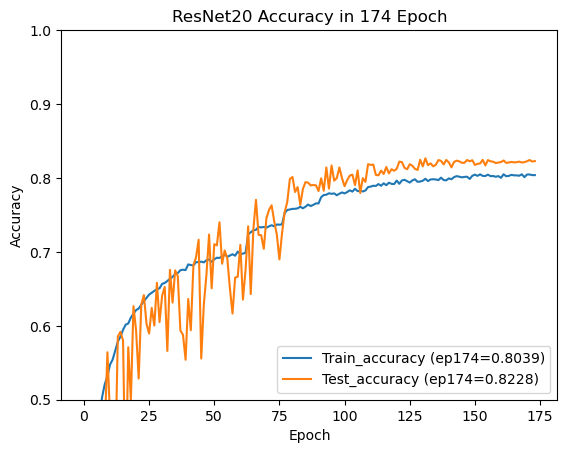

In [30]:
train_acc = history.history['accuracy'][-1]
test_acc  = history.history['val_accuracy'][-1]

# （accuracy vs epochs）
plt.plot(history.history['accuracy'],
         label=f"Train_accuracy (ep174={train_acc:.4f})") 
plt.plot(history.history['val_accuracy'],
         label=f"Test_accuracy (ep174={test_acc:.4f})") 
plt.xlabel('Epoch')  # X 轴标签：（Epoch）
plt.ylabel('Accuracy')  # Y 轴标签：（Accuracy）
plt.ylim([0.5, 1]) 
plt.title('ResNet20 Accuracy in 174 Epoch') 
plt.legend(loc='lower right')  

plt.savefig(r'C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\training history\ResNet20_174Epoch.png') 
plt.show()  


In [31]:
import pandas as pd

history_dict = history.history

df = pd.DataFrame({
    "Train_accuracy": history_dict["accuracy"],
    "Train_loss": history_dict["loss"],
    "Test_accuracy": history_dict["val_accuracy"],
    "Test_loss": history_dict["val_loss"]
})

excel_filename = "training_history.xlsx"
df.to_excel(excel_filename, index=False)

df_history = pd.DataFrame(history.history)
df_history.to_csv('history.csv', index=False)


In [32]:
print(test_acc)

0.8227999806404114


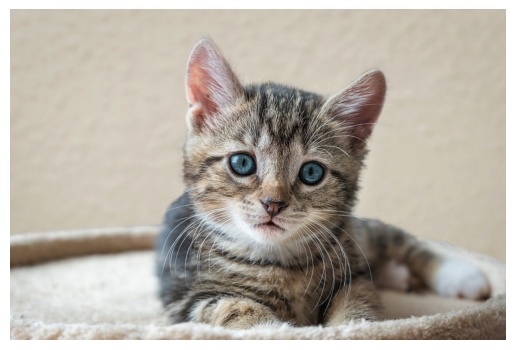

In [8]:

img = cv2.imread(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\cat.jpg")  

img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_cvt)
plt.axis('off') 
plt.show()


In [9]:

img = cv2.resize(img_cvt, (32,32))
img = img.astype('float32')
img= img / 255.0
imgs = tf.expand_dims(
    img,
    axis=0,
    name=None
)
model.predict(imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


array([[0.03210302, 0.01852119, 0.02790785, 0.31402797, 0.02551235,
        0.03454543, 0.0723646 , 0.04427529, 0.4061181 , 0.02462429]],
      dtype=float32)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


C:\Users\MI\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


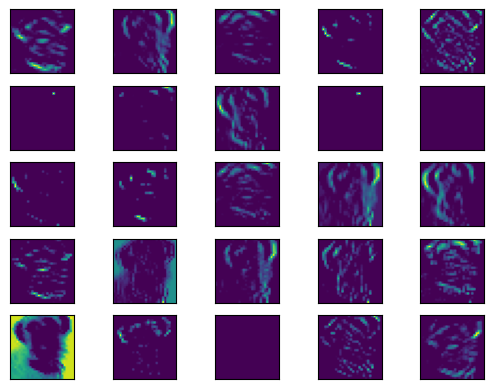

In [45]:


i=4


square = 5
ix = 1

model2 = Model(inputs=model.inputs, outputs=model.layers[i].output)

model2.summary()

feature_maps = model2.predict(imgs)
    
for _ in range(square):
  for _ in range(square):
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])  
        ax.set_yticks([]) 
        
        pyplot.imshow(feature_maps[0, :, :, ix-1])

        ix += 1

pyplot.show()
